In [1]:
# %%
from attribution_utils import calculate_feature_attribution
from collections import defaultdict
from torch.nn.functional import log_softmax
from gemma_utils import get_all_string_min_l0_resid_gemma
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils
from functools import partial
import tqdm
from sae_lens import HookedSAETransformer, SAE, SAEConfig
from gemma_utils import get_gemma_2_config, gemma_2_sae_loader
import numpy as np
import torch
import tqdm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
all_tuples = torch.load("all_tuples_dict_top_50_item_pos.pt")

In [ ]:


# Compute the proportion of intersection
def compute_proportion_intersection(tups0,tups1,use_position = False):
    intersect01 = []
    for tup0,tup1 in zip(tups0,tups1):
        if use_position:
            intersec = set(tup0).intersection(set(tup1))
        else:
            # just use the feature ids
            intersec = set([feat for pos,feat in tup0]).intersection(set([feat for pos,feat in tup1])) 
        intersect01.append(len(intersec)/len(tup0))
    return np.mean(intersect01)

In [18]:
def get_pairwise_intersection_prop(all_tuples,use_position):
    mat_prop = np.zeros((len(all_tuples),len(all_tuples)))
    for i,(topic1,topic1_dict) in enumerate(all_tuples.items()): 
        for j,(topic2,topic2_dict) in enumerate(all_tuples.items()): 
            average_prop = 0
            for eg1,eg_list1 in topic1_dict.items():
                for eg2,eg_list2 in topic2_dict.items():
                    average_prop += compute_proportion_intersection(eg_list1,eg_list2, use_position=use_position)
            mat_prop[i,j] = average_prop/len(all_tuples)
    return mat_prop


            

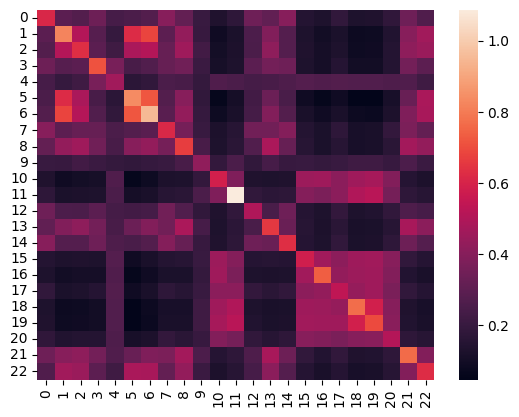

In [19]:
mat_prop = get_pairwise_intersection_prop(all_tuples, True)
sns.heatmap(mat_prop)
plt.show()

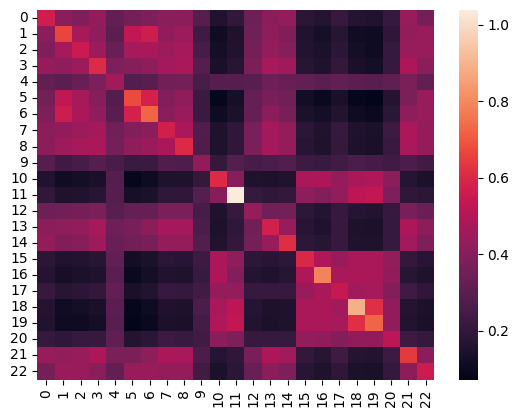

In [20]:
mat_prop = get_pairwise_intersection_prop(all_tuples, False)
sns.heatmap(mat_prop)
plt.show()

## Get the top features

In [30]:
from collections import Counter
all_features_by_layer = defaultdict(list) 

for topic,topic_dict in all_tuples.items(): 
        for eg,eg_list in topic_dict.items():
            for i,tup in enumerate(eg_list):
                  all_features_by_layer[i].extend(tup)


counter_per_layer = {} 
for key,val in all_features_by_layer.items():
    counter_per_layer[key] = Counter(val)

# Get the top 10 features per layer
top_features_per_layer = {}
for key,val in counter_per_layer.items():
    top_features_per_layer[key] = val.most_common(10)
    print(key)
    print(val.most_common(10))
    print("====")

## Get the top features without position

In [42]:
# Get the top features without position
from collections import Counter
all_features_by_layer = defaultdict(list) 

for topic,topic_dict in all_tuples.items(): 
        for eg,eg_list in topic_dict.items():
            for i,tup in enumerate(eg_list):
                  all_features_by_layer[i].extend([feat for pos,feat in tup])


counter_per_layer = {} 
for key,val in all_features_by_layer.items():
    counter_per_layer[key] = Counter(val)

# Get the top 10 features per layer
top_features_per_layer = {}
for key,val in counter_per_layer.items():
    top_features_per_layer[key] = val.most_common(10)
    print(key)
    print(val.most_common(10))
    print("====")

0
[(16300, 345), (8685, 297), (15101, 137), (8613, 109), (7636, 97), (4725, 79), (10961, 79), (8198, 78), (16158, 78), (14811, 74)]
====
1
[(13789, 671), (4209, 219), (2841, 191), (8286, 154), (697, 85), (679, 83), (9374, 78), (7541, 72), (455, 70), (12820, 68)]
====
2
[(12541, 574), (11772, 471), (4286, 242), (13146, 215), (3406, 164), (8770, 139), (4472, 128), (16059, 103), (8839, 94), (16223, 93)]
====
3
[(4300, 428), (13370, 259), (8610, 174), (16309, 145), (8027, 128), (7746, 127), (11025, 113), (7539, 104), (10349, 101), (11154, 88)]
====
4
[(3013, 306), (14923, 160), (4365, 132), (9268, 129), (8996, 119), (11528, 113), (9797, 101), (7485, 98), (12513, 97), (9550, 82)]
====


In [41]:
# Get the top features with position
from collections import Counter
all_features_by_layer = defaultdict(list) 

for topic,topic_dict in all_tuples.items(): 
        for eg,eg_list in topic_dict.items():
            for i,tup in enumerate(eg_list):
                  all_features_by_layer[i].extend([(pos,feat) for pos,feat in tup if pos >0])


counter_per_layer = {} 
for key,val in all_features_by_layer.items():
    counter_per_layer[key] = Counter(val)
top_features_per_layer = {}
for key,val in counter_per_layer.items():
    top_features_per_layer[key] = val.most_common(10)
    print(key)
    print(val.most_common(10))
    print("====")



0
[((11, 4725), 79), ((9, 8198), 78), ((13, 14811), 74), ((7, 1577), 62), ((4, 7636), 57), ((13, 7728), 55), ((10, 13667), 53), ((13, 16174), 50), ((13, 1046), 46), ((13, 16100), 45)]
====
1
[((13, 13789), 81), ((11, 13789), 72), ((9, 7541), 72), ((11, 12053), 62), ((8, 11329), 56), ((8, 697), 54), ((6, 13789), 50), ((7, 4970), 45), ((31, 13789), 44), ((12, 13789), 42)]
====
2
[((31, 11772), 54), ((16, 11772), 48), ((15, 8770), 45), ((27, 12541), 45), ((8, 12541), 43), ((15, 11772), 43), ((13, 4472), 42), ((16, 8770), 41), ((20, 12541), 41), ((7, 12541), 40)]
====
3
[((31, 4300), 58), ((3, 16309), 53), ((32, 4300), 31), ((45, 4300), 30), ((44, 4300), 25), ((30, 4300), 25), ((63, 13370), 23), ((46, 4300), 23), ((61, 13370), 20), ((65, 13370), 20)]
====
4
[((30, 3013), 42), ((31, 3013), 32), ((30, 8996), 28), ((34, 11171), 22), ((46, 3013), 21), ((37, 11171), 21), ((35, 9268), 17), ((44, 4365), 16), ((46, 4365), 14), ((46, 6978), 14)]
====


## Dashboard

In [46]:
# instantiate an object to hold activations from a dataset
from sae_lens import ActivationsStore
from sae_lens import HookedSAETransformer, SAE, SAEConfig

model = HookedSAETransformer.from_pretrained("gpt2")
full_strings = get_all_string_min_l0_resid_gemma()
layer = 5 
saes_dict = {}

with torch.no_grad():
    repo_id = "google/gemma-scope-2b-pt-res"
    folder_name = full_strings[layer]
    config = get_gemma_2_config(repo_id, folder_name)
    cfg, state_dict, log_spar = gemma_2_sae_loader(repo_id, folder_name)
    sae_cfg = SAEConfig.from_dict(cfg)
    sae = SAE(sae_cfg)
    sae.load_state_dict(state_dict)
    sae.to("cuda:0")
    sae.use_error_term = True
    saes_dict[sae.cfg.hook_name] = sae


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


/root/GemmaExploration/gemma_utils.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resid_dict = df[df['release'] == "gemma-scope-2b-pt-res"]['saes_map'][0]


In [43]:
generation_dict = torch.load("generation_dicts/gemma2_generation_dict.pt")
toks = generation_dict["Vegetables"][0]

In [48]:
model.add_sae(sae)
_,cache = model.run_with_cache(toks)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

# a convenient way to instantiate an activation store is to use the from_sae method
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    # fairly conservative parameters here so can use same for larger
    # models without running out of memory.
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=32,
    device="cuda:0",
)

def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

# A very handy function Neel wrote to get context around a feature activation
def make_token_df(tokens, len_prefix=5, len_suffix=3, model = model):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        prompt=prompt,
        pos=pos,
        label=label,
    ))

# finding max activating examples is a bit harder. To do this we need to calculate feature activations for a large number of tokens
feature_list = torch.randint(0, sae.cfg.d_sae, (100,))
examples_found = 0
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

total_batches = 100
batch_size_prompts = activation_store.store_batch_size_prompts
batch_size_tokens = activation_store.context_size * batch_size_prompts
pbar = tqdm(range(total_batches))
for i in pbar:
    tokens = activation_store.get_batch_tokens()
    tokens_df = make_token_df(tokens)
    tokens_df["batch"] = i
    
    flat_tokens = tokens.flatten()
    
    _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])
    sae_in = cache[sae.cfg.hook_name]
    feature_acts = sae.encode(sae_in).squeeze()

    feature_acts = feature_acts.flatten(0,1)
    fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
    fired_tokens = model.to_str_tokens(flat_tokens[fired_mask])
    reconstruction = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

    token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
    all_token_dfs.append(token_df)
    all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
    all_fired_tokens.append(fired_tokens)
    all_reconstructions.append(reconstruction)
    
    examples_found += len(fired_tokens)
    # print(f"Examples found: {examples_found}")
    # update description
    pbar.set_description(f"Examples found: {examples_found}")
    
# flatten the list of lists
all_token_dfs = pd.concat(all_token_dfs)
all_fired_tokens = list_flatten(all_fired_tokens)
all_reconstructions = torch.cat(all_reconstructions)
all_feature_acts = torch.cat(all_feature_acts)